# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
!pip install --upgrade numpy scipy numba -q

In [ ]:
!pip install scikit-learn==1.4.2 -q

In [ ]:
!pip install  matplotlib --upgrade -q

In [ ]:
!pip install  seaborn --upgrade -q

In [ ]:
!pip install phik -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import phik

from scipy import stats as st
from scipy.stats import pearsonr, spearmanr, shapiro

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

TEST_SIZE = 0.25
RANDOM_STATE = 42

In [ ]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [ ]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [ ]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: формат таблиц корректный. Пропусков нет.  </p>
</div>

### Поиск и обработка дубликатов

In [ ]:
def duplicates_df(df,name):
    duplicates = df[df.duplicated()]
    if  duplicates.empty:
        print(f'Явных дубликатов для {name} не обнаружено.')
    else:
        print(f'Обнаружены явные дубликаты для {name}:')
    return

In [ ]:
duplicates_df(geo_data_0,'geo_data_0')
duplicates_df(geo_data_1,'geo_data_1')
duplicates_df(geo_data_2,'geo_data_2')

Явных дубликатов для geo_data_0 не обнаружено.
Явных дубликатов для geo_data_1 не обнаружено.
Явных дубликатов для geo_data_2 не обнаружено.


In [ ]:
def hidden_duplicates_df(df,name,subset):
    unique_df = df.drop_duplicates(subset=subset)
    duplicates = len(df) - len(unique_df)
    if len(df) == len(unique_df):
        print(f'нет неявных дубликатов в датафрейме {name}')
    else:
        print(f'есть неявные дубликаты в датафрейме {name}, кол-во дубликатов: {duplicates}')

In [ ]:
hidden_duplicates_df(geo_data_0,'geo_data_0', ['id'])
hidden_duplicates_df(geo_data_1,'geo_data_1', ['id'])
hidden_duplicates_df(geo_data_2,'geo_data_2', ['id'])

есть неявные дубликаты в датафрейме geo_data_0, кол-во дубликатов: 10
есть неявные дубликаты в датафрейме geo_data_1, кол-во дубликатов: 4
есть неявные дубликаты в датафрейме geo_data_2, кол-во дубликатов: 4


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: явных дубликатов не обнаружено, названия некоторых скважен повторяются, нужно удалить неявные дубликаты. </p>
</div>

In [ ]:
geo_data_0.drop_duplicates(subset=['id'], inplace=True)
geo_data_1.drop_duplicates(subset=['id'], inplace=True)
geo_data_2.drop_duplicates(subset=['id'], inplace=True)

## Исследовательский анализ данных
Наиболее информативно будет пранализировать столбец product

Исследовательский анализ столбца 'product':
Основные статистики:
count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64


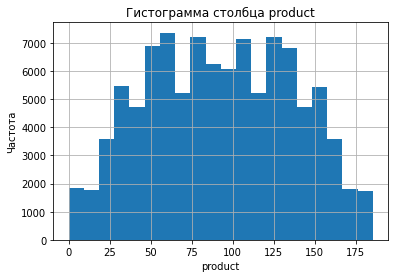

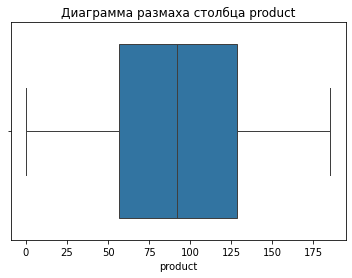

Исследовательский анализ столбца 'product':
Основные статистики:
count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64


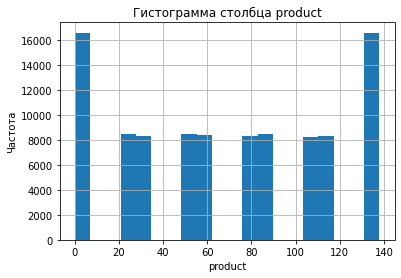

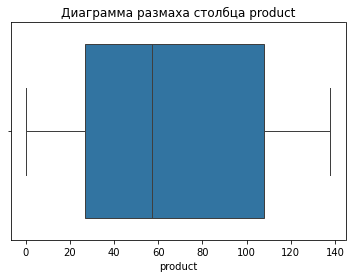

Исследовательский анализ столбца 'product':
Основные статистики:
count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838
Name: product, dtype: float64


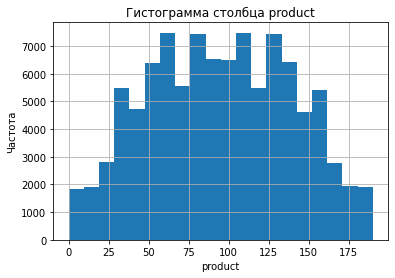

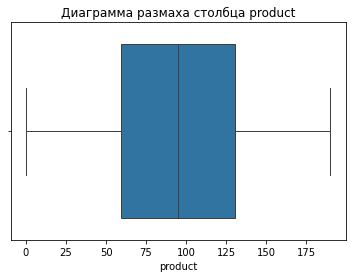

In [ ]:
def explore(df, column):
    column_data = df[column]
    print("Исследовательский анализ столбца '{}':".format(column))
    print("Основные статистики:")
    print(column_data.describe())

    column_data.hist(bins=20)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title('Гистограмма столбца {}'.format(column))
    plt.show()
    sns.boxplot(x=column_data)
    plt.xlabel(column)
    plt.title('Диаграмма размаха столбца {}'.format(column))
    plt.show()

explore(geo_data_0,'product')
explore(geo_data_1,'product')
explore(geo_data_2,'product')

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: данные трех регионов отличаются, для региона - 1, данные раздроблены и имеют значительное количство значений, как максимальных так и минимальных. </p>
</div>

In [ ]:
geo_data_0.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [ ]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


### Корреляционный анализ

In [ ]:
import warnings
warnings.filterwarnings('ignore')

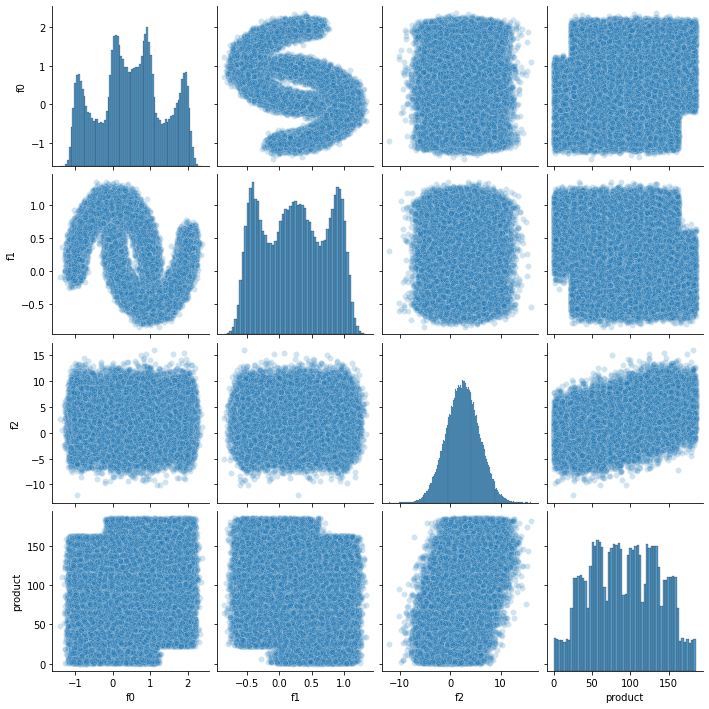

In [ ]:
def plot(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64'])
    sns.pairplot(numerical_features, palette='Set1', plot_kws={'alpha': 0.2})
    plt.show()

plot(geo_data_0)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: анализ корреляции показал незначительную линейную зависимость между целевым признаком и f2. </p>
</div>

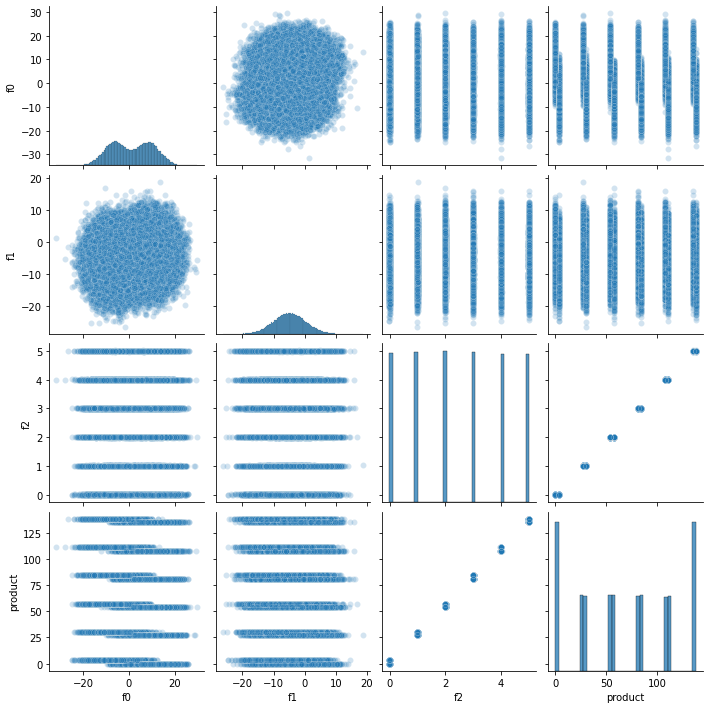

In [ ]:
plot(geo_data_1)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: анализ корреляции показал  корреляцию между целевым признаком и f2. Данные в датафрейме дискретны </p>
</div>

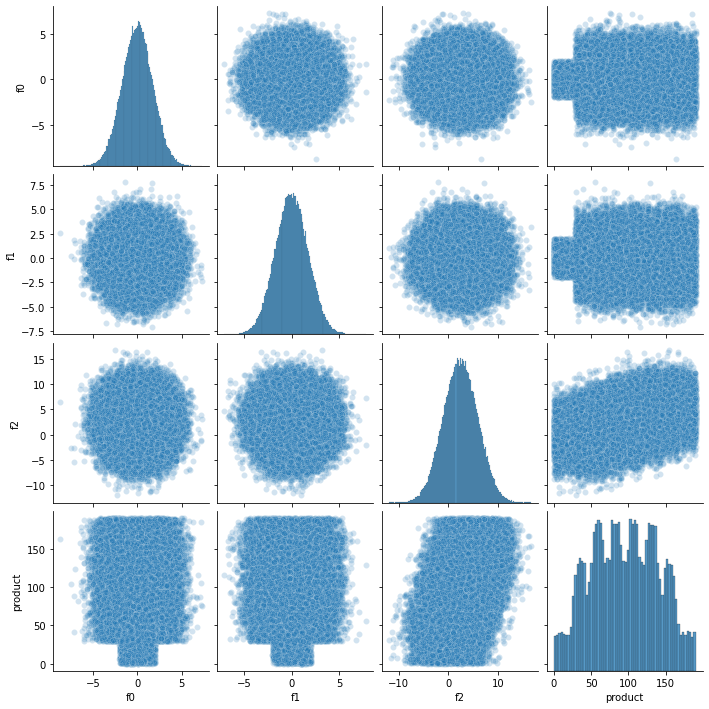

In [ ]:
plot(geo_data_2)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: анализ корреляции показал незначительную корреляцию между целевым признаком и f2.  </p>
</div>

#### Матрица корреляции

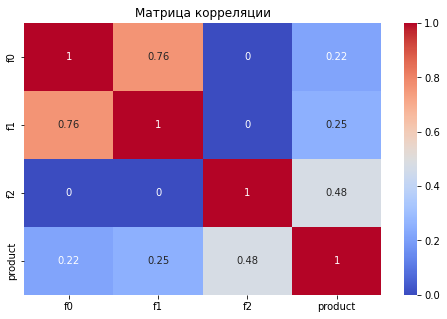

In [ ]:
def corr_matrix(df, interval_col):
    columns_list = df.columns.difference(['id'])
    correlation_matrix = df[columns_list].phik_matrix(interval_cols=interval_col)
    plt.figure(figsize=(8, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Матрица корреляции')
    plt.show()

col = ['f0', 'f1', 'f2', 'product']
corr_matrix(geo_data_0, col)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: матрица корреляции показала среднюю корреляцию между целевым признаком и f2, а так же высокую между признаком f0 и f1 </p>
</div>

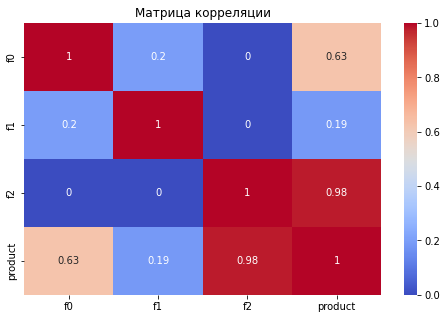

In [ ]:
corr_matrix(geo_data_1, col)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: матрица корреляции показала очень высокую корреляцию между целевым признаком и f2, а так же среднюю корреляции между целевым признаком и f0. </p>
</div>

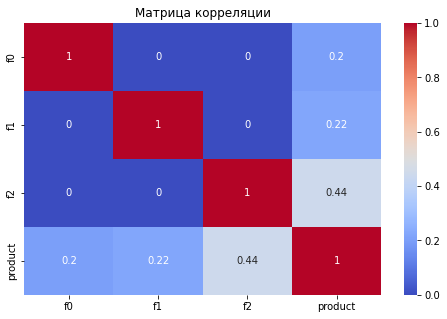

In [ ]:
corr_matrix(geo_data_2, col)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: матрица корреляции показала среднюю корреляцию между целевым признаком и f2, а так же отсутвия корреляции между признаками. </p>
</div>

## Обучение и проверка модели
Создадим функцию и пайплайн для подготовки данных и обучения моделей линейной регрессии

In [ ]:
pred_dict = {}

def prepare_data(df, target, model, i):
    global pred_dict  # Объявляем pred_dict как глобальную переменную

    X_train, X_valid, y_train, y_valid = train_test_split(df, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_valid)
    mean_production = np.mean(predictions)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))

    pred_product = pd.DataFrame(predictions, columns=['predictions'], index=y_valid.index)
    region_name = f'pred_product_{i}'
    pred_dict[region_name] = pred_product

    print(f"Регион {i}:")
    print("Средний запас предсказанного сырья:", mean_production)
    print("RMSE модели:", rmse)

    return pd.concat([y_valid, pred_product], axis=1)

num_columns = ['f0', 'f1', 'f2']
region_1_data = prepare_data(geo_data_0[num_columns], geo_data_0['product'], LinearRegression(), 1)
region_2_data = prepare_data(geo_data_1[num_columns], geo_data_1['product'], LinearRegression(), 2)
region_3_data = prepare_data(geo_data_2[num_columns], geo_data_2['product'], LinearRegression(), 3)

all_regions_data = pd.concat([region_1_data, region_2_data, region_3_data],
                             keys=['region_1', 'region_2', 'region_3'], names=['region'])

Регион 1:
Средний запас предсказанного сырья: 92.60984027552017
RMSE модели: 37.68508926201444
Регион 2:
Средний запас предсказанного сырья: 68.57703454115173
RMSE модели: 0.8928265978121422
Регион 3:
Средний запас предсказанного сырья: 94.93478722287514
RMSE модели: 40.080822438088305


In [ ]:
region_1_data.head()

,product,predictions
33966,119.813252,127.486528
22854,133.296862,116.465831
19449,25.310435,66.041910
9733,65.422491,45.009390
7129,140.851476,124.535557


In [ ]:
region_1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24998 entries, 33966 to 37002
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product      24998 non-null  float64
 1   predictions  24998 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


In [ ]:
region_2_data.head()

,product,predictions
33968,0.000000,1.745635
24612,134.766305,135.730891
42678,134.766305,133.539653
9732,30.132364,28.844517
7129,137.945408,138.037182


In [ ]:
region_2_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24999 entries, 33968 to 92473
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product      24999 non-null  float64
 1   predictions  24999 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


In [ ]:
region_3_data.head()

,product,predictions
33968,156.925842,111.540811
24612,31.245818,66.812289
42677,48.478519,70.406921
9732,34.079047,63.118690
7129,138.077543,141.162178


In [ ]:
region_3_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24999 entries, 33968 to 92472
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product      24999 non-null  float64
 1   predictions  24999 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: по метрике RMSE лучше всего показала себя модель обученная на данных второго региона. Но наибольший средний запас сырья у данных третьего региона. </p>
</div>

## Подготовка к расчёту прибыли

In [ ]:
BUDGET = 10000000000  # Бюджет на разработку в рублях
REVENUE_PER_UNIT = 450000  # Доход с каждой единицы продукта в рублях (450 руб/баррель * 1000 баррелей)
NUMBER_OF_WELLS = 200  # Количество скважин для разработки
TOTAL_POINTS = 500  # Общее количество исследованных точек

In [ ]:
break_even_volume = BUDGET / (REVENUE_PER_UNIT * NUMBER_OF_WELLS)
print(f"Достаточный объем сырья для безубыточной разработки: {break_even_volume} тыс. баррелей")

Достаточный объем сырья для безубыточной разработки: 111.11111111111111 тыс. баррелей


In [ ]:
mean_predictions = {
    'Регион 1': region_1_data['predictions'].mean(),
    'Регион 2': region_2_data['predictions'].mean(),
    'Регион 3': region_3_data['predictions'].mean(),
}

for region, mean_prediction in mean_predictions.items():
    print(f"{region} - Средний запас предсказанного сырья: {mean_prediction} тыс. баррелей")

Регион 1 - Средний запас предсказанного сырья: 92.60984027552017 тыс. баррелей
Регион 2 - Средний запас предсказанного сырья: 68.57703454115173 тыс. баррелей
Регион 3 - Средний запас предсказанного сырья: 94.93478722287514 тыс. баррелей


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: Для безубыточной разработки требуется 111.1 тыс. баррелей. Это на 19 тыс., 43 тыс. и 17 тыс. больше среднего запаса предсказанного сырья в регионах 1, 2 и 3 соответственно. Следовательно, наибольшую уверенность можно иметь в данных для второго региона, поскольку предсказательная способность моделей для других регионов слишком низкая. </p>
</div>

In [ ]:
def calculate_profit(df, pred_col, product_col):
    prof = df.sort_values(pred_col, ascending=False)[product_col]
    best_prof = prof.head(NUMBER_OF_WELLS).sum()
    return best_prof * REVENUE_PER_UNIT - BUDGET

## Расчёт прибыли и рисков

In [ ]:
profit_1 = calculate_profit(region_1_data,'predictions','product')
profit_2 = calculate_profit(region_2_data,'predictions','product')
profit_3 = calculate_profit(region_3_data,'predictions','product')

print(f"Прибыль по региону 1: {profit_1 / 1e6:.2f} млн. руб")
print(f"Прибыль по региону 2: {profit_2 / 1e6:.2f} млн. руб")
print(f"Прибыль по региону 3: {profit_3 / 1e6:.2f} млн. руб")

Прибыль по региону 1: 3468.53 млн. руб
Прибыль по региону 2: 2415.09 млн. руб
Прибыль по региону 3: 2396.61 млн. руб


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: Наибольшая прибыль по предсказанным результатам у 1 региона. </p>
</div>

In [ ]:
state = np.random.RandomState(RANDOM_STATE)


def bootstrap_profit(df, pred_col, product_col):
    profits = []
    for i in range(1000):
        sample_indices = state.choice(df.index, size=TOTAL_POINTS, replace=True)
        sample_df = df.loc[sample_indices]
        profit = calculate_profit(sample_df, pred_col, product_col)
        profits.append(profit)

    profits = pd.Series(profits)
    lower_bound = profits.quantile((1 - 0.95) / 2)
    upper_bound = profits.quantile(1 - (1 - 0.95) / 2)
    mean_profit = profits.mean()
    loss_risk = (profits < 0).mean() * 100

    return mean_profit, lower_bound, upper_bound, loss_risk

mean_profit_1, lower_bound_1, upper_bound_1, loss_risk_1 = bootstrap_profit(region_1_data, 'predictions', 'product')
mean_profit_2, lower_bound_2, upper_bound_2, loss_risk_2 = bootstrap_profit(region_2_data, 'predictions', 'product')
mean_profit_3, lower_bound_3, upper_bound_3, loss_risk_3 = bootstrap_profit(region_3_data, 'predictions', 'product')

print("Регион 1:")
print(f"Средняя прибыль: {mean_profit_1 / 1e6:.2f} млн. руб")
print(f"95%-й доверительный интервал: ({lower_bound_1 / 1e6:.2f}, {upper_bound_1 / 1e6:.2f}) млн. руб")
print(f"Риск убытков: {loss_risk_1:.2f}%")

print("\nРегион 2:")
print(f"Средняя прибыль: {mean_profit_2 / 1e6:.2f} млн. руб")
print(f"95%-й доверительный интервал: ({lower_bound_2 / 1e6:.2f}, {upper_bound_2 / 1e6:.2f}) млн. руб")
print(f"Риск убытков: {loss_risk_2:.2f}%")

print("\nРегион 3:")
print(f"Средняя прибыль: {mean_profit_3 / 1e6:.2f} млн. руб")
print(f"95%-й доверительный интервал: ({lower_bound_3 / 1e6:.2f}, {upper_bound_3 / 1e6:.2f}) млн. руб")
print(f"Риск убытков: {loss_risk_3:.2f}%")

if mean_profit_1 > mean_profit_2 and mean_profit_1 > mean_profit_3:
    best_region = 1
elif mean_profit_2 > mean_profit_1 and mean_profit_2 > mean_profit_3:
    best_region = 2
else:
    best_region = 3

print(f"\nРекомендуется разработка в регионе {best_region}, так как он имеет наибольшую среднюю прибыль.")

Регион 1:
Средняя прибыль: 403.57 млн. руб
95%-й доверительный интервал: (-137.69, 902.85) млн. руб
Риск убытков: 5.90%

Регион 2:
Средняя прибыль: 439.36 млн. руб
95%-й доверительный интервал: (31.75, 845.88) млн. руб
Риск убытков: 1.60%

Регион 3:
Средняя прибыль: 367.70 млн. руб
95%-й доверительный интервал: (-169.19, 877.13) млн. руб
Риск убытков: 8.00%

Рекомендуется разработка в регионе 2, так как он имеет наибольшую среднюю прибыль.


## Вывод

На основе проведенного анализа прибыли и рисков, данные следующие:

**Регион 1:**
- Средняя прибыль: 403.57 млн. руб
- 95%-й доверительный интервал: (-137.69, 902.85) млн. руб
- Риск убытков: 5.90%

**Регион 2:**
- Средняя прибыль: 439.36 млн. руб
- 95%-й доверительный интервал: (31.75, 845.88) млн. руб
- Риск убытков: 1.60%

**Регион 3:**
- Средняя прибыль: 367.70 млн. руб
- 95%-й доверительный интервал: (-169.19, 877.13) млн. руб
- Риск убытков: 8.00%


**Вывод и рекомендация:**

- Средняя прибыль наибольшая в регионе 2 (439.36 млн. руб.).
- Риски убытков в регионе 1 (5.90%) и 3 (8.00%) несколько выше, чем в регионе 2 (1.60%).
- Наиболее узкий доверительный интервал: Регион 3 (707.94 млн. руб)
- Наибольшая минимальная прибыль: Регион 2 (31.75 млн. руб)

**Рекомендация: Рекомендуется разработка в Регионе 2, так как он имеет наибольшую среднюю прибыль (439.36 млн. руб) и низкий риск убытков (1.60%).**